In [1]:
import matplotlib.pyplot as plt
import numpy as np

from src.CipherBreaker import CipherBreaker
from src.CipherUtils import (
    TextDecoder,
    TextEncoder,
    CipherGenerator,
    TextPreProcessor,
)
from src.ProbabilityMatrix import ProbabilityMatrix

from difflib import SequenceMatcher

In [2]:
def similar(a, b):
    """
    Given two strings a, b it returns a percentage of matching characters among the two
    """

    return SequenceMatcher(None, a.replace(" ", ""), b.replace(" ", "")).ratio() 

In [3]:
# Initialize classes and obtain the matrix of probabilities by training on the provided text
cipher_generator = CipherGenerator()
preprocess = TextPreProcessor()
text_encoder = TextEncoder()
text_decoder = TextDecoder()


# List of text file paths to build our corpus (where we learn the transitions probs)
file_paths = [
    "texts/moby_dick.txt",
    "texts/shakespeare.txt",
    "texts/james-joyce-a-portrait-of-the-artist-as-a-young-man.txt",
    "texts/james-joyce-dubliners.txt",
    "texts/james-joyce-ulysses.txt",
]

texts = []
for file_path in file_paths:
    with open(file_path, "r") as file:
        texts.append(file.read())

corpus = "".join(texts)


# preprocess the text, removing extra-characters

corpus = preprocess.lower(corpus)
unknown_chars = preprocess.unknown_chars(corpus)
# print(unknown_chars)
corpus = preprocess.remove_unknown_chars(corpus, unknown_chars=unknown_chars)
corpus = preprocess.remove_additional_spaces(corpus)

preprocess.save_text(
    corpus
)  # save text after preprocessing inside text_preprocessed.txt


# compute the transition probs
probability_matrix = ProbabilityMatrix(corpus)
probability_matrix.compute_probability_table()

probability_matrix.save_all_2_chars()
probability_matrix.save_probability_table()

In [52]:
lengths = [2**(i+3) for i in range(6)] # length of text in terms of number of words we want to consider
lengths

[8, 16, 32, 64, 128, 256, 512, 1024]

In [5]:
def prepare_subtexts(path_to_file, lengths):
    """
    This function returns the subtext to use to assess accuracy in decryption

    Input: 
        - path_to_file (str) giving the path to the text file
        - lengths (list of int) giving the text lengths to consider
    """

    with open(path_to_file, 'r') as input_file:
        full_text = input_file.read()

    full_text = preprocess.lower(full_text)
    unknown_chars = preprocess.unknown_chars(full_text)
    # print(unknown_chars)
    full_text = preprocess.remove_unknown_chars(full_text, unknown_chars=unknown_chars)
    full_text = preprocess.remove_additional_spaces(full_text)

    subtexts = [" ".join(full_text.split()[:lengths[i]]) for i in range(len(lengths))] # Contains the ones for the varying lengths

    return subtexts

In [43]:
def accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix, extract_top = 5, n_iterations = 5, max_iterations = 10000, nstart = 5):
    """
    This function assesses the accuracy of the MCMC decryption.
    Input:
        - subtexts (list of str): a vector of text of different length
        - cipher_generator (CipherGenerator instance)
        - probability_matrix 
        - extract_top(int) : After cipher breaking how many of the top ones we want to retain
        - n_iterations (int) : number of times we want to repeat the encryption-decryption for each text
        - max_iterations (int) : number of iterations in the cipher breaking procedure
        - nstart (int) : number of starting points in the cipher breaking procedure

    For each subtext it encrypts it and decrypts it n_iteration times. 
        Everytime it finishes decrypting it compares the best extract_top (in terms of log likelihood) with the original string, 
        and computes the accuracy as the proportion of characters matching for the string which matches best.
        Then for each subtext these are averaged over all n_iterations runs and are stored.
    """
    mean_accuracy = []

    for subtext in subtexts:


        total_iterations = 0
        for _ in range(n_iterations):
            cipher = cipher_generator.generate_cipher()
            encoded_text = text_encoder.encode_text(subtext, cipher)

            # Initialize a code breaker for that encoded message
            cipher_breaker_nstart = CipherBreaker(
                cipher_generator = cipher_generator, 
                ciphered_text=encoded_text,
                probability_table=probability_matrix.probability_table,
            )
            
            # Break the code and store the extract_top in a dictionary (avoid printing)
            cipher_breaker_nstart.break_cipher_nstart(iterations=max_iterations, print_interval=max_iterations, nstart = nstart)
            best_dict = cipher_breaker_nstart.extract_best(
                            n_extract=extract_top, return_likelihood=True
                        )  

            # Extract only the text and store it in a list
            best_dict_text = [t[0] for t in best_dict]
            print(best_dict_text)

            # Now we check the percentage of correct ones in the string we matched the most with
            total_iterations = total_iterations + max([ similar(subtext, best_dict_text[l]) for l in range(len(best_dict_text)) ])
        

        mean_accuracy.append(total_iterations/n_iterations)


    return mean_accuracy

In [44]:
# An example which runs very fast
subtexts = prepare_subtexts("texts/moby_dick.txt", [2*i for i in range(2,6)])
accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix)

Iter 0 of start 1: wfgundj xccmypah wgxx md
Iter 0 of start 2: jweotlz immnvbxd jeii nl
Iter 0 of start 3: ucemwzh brritnkv uebb iz
Iter 0 of start 4: vnzgijp bhhamfse vzbb aj
Iter 0 of start 5: nbphozs fllaeuvq npff az
['thimurd seeaclon tiss ar', 'thimurd seeaplon tiss ar', 'thiburd seeaclon tiss ar', 'healids toongqfr hatt nd', 'thimord seeaplxn tiss ar']
Iter 0 of start 1: adjvsry pllzmfho ajpp zr
Iter 0 of start 2: rfmkujt vggnqicd rmvv nj
Iter 0 of start 3: qpgrnze laayhxcb qgll yz
Iter 0 of start 4: nkacduj wllhfqte naww hu
Iter 0 of start 5: oquztac ywwbhpvf ouyy ba
['cwhestr ommalind choo at', 'arsuthe loowqind asll wh', 'cwhisty ellabond chee at', 'ndioumy sllather niss am', 'cwhisty ellabund chee at']
Iter 0 of start 1: rboutel zppqykic rozz qe
Iter 0 of start 2: trmdauy ojjvhfnq tmoo vu
Iter 0 of start 3: jpyaenf woobcrdx jyww bn
Iter 0 of start 4: qgetcnk faaplduv qeff pn
Iter 0 of start 5: bmdvzjw rccupqis bdrr uj
['asthxnd ollicwer atoo in', 'asthznd ollicwer atoo in', '

[0.41904761904761906, 0.2875, 0.32499999999999996, 0.31020408163265306]

In [46]:
lengths = [2*i for i in range(4,7)]

In [52]:
# Use it on the Moby Dick text 
subtexts = prepare_subtexts("texts/moby_dick.txt", lengths)
Moby_Dick_accuracy = accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix)


# Use it on the article text 
subtexts = prepare_subtexts("texts/article_tipping.txt", lengths)
article_tipping_accuracy = accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix)

# Use it on the war message text
subtexts = prepare_subtexts("texts/eisenhower_speech.txt", lengths)
speech_accuracy = accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix)


Iter 0 of start 1: ulixszw oaacqjhg uioo cz qglcizo gacz fziwg iha
Iter 0 of start 2: mulqcke vpprsnbg mlvv rk sgurlkv gprk dkleg lbp
Iter 0 of start 3: dlsictm bggorxwn dsbb ot rnlostb ngot atsmn swg
Iter 0 of start 4: dzfpchq roowvmat dfrr wh vtzwfhr towh xhfqt fao
Iter 0 of start 5: ruisbgn offvdehk rioo vg dkuvigo kfvg lgink ihf
['cwiuled stthrano ciss he rowhies othe meido int', 'cwailer stthbuno cass he bowhaes othe dearo ant', 'cwailer stthbxno cass he bowhaes othe dearo ant', 'cwiuged stthrano ciss he rowhies othe meido int', 'cwaiged stthruno cass he rowhaes othe meado ant']
Iter 0 of start 1: ucvdsar oppqbtie uvoo qa becqvao epqa wavre vip
Iter 0 of start 2: epwahiz mkkgjcno ewmm gi jopgwim okgi riwzo wnk
Iter 0 of start 3: uwavfei qkkrsocb uaqq re sbwraeq bkre zeaib ack
Iter 0 of start 4: wfdpqjo emmiulgt wdee ij utfidje tmij njdot dgm
Iter 0 of start 5: caquygi zssvnted cqzz vg ndavqgz dsvg xgqid qes
['cwalyer stthiuno cass he iowhaes othe bearo ant', 'cwavper stthiuno cass

In [53]:
print("Moby Dick accuracy", Moby_Dick_accuracy)
print("Article accuracy", article_tipping_accuracy)
print("Eisenhower speech accuracy", speech_accuracy)

Moby Dick accuracy [0.27999999999999997, 0.2857142857142857, 0.3928571428571428]
Article accuracy [0.3466666666666667, 0.26222222222222225, 0.36923076923076925]
Eisenhower speech accuracy [0.3, 0.32765957446808514, 0.3615384615384615]


In [79]:
# Write results to file
with open("outputs/MCMC_accuracies/Moby_Dick_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in Moby_Dick_accuracy:
        file.write(str(num) + '\n')

with open("outputs/MCMC_accuracies/Article_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in article_tipping_accuracy:
        file.write(str(num) + '\n')

with open("outputs/MCMC_accuracies/speech_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in speech_accuracy:
        file.write(str(num) + '\n')

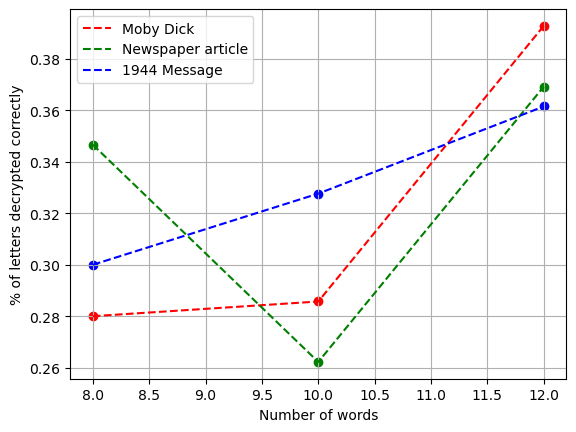

In [62]:

# Plotting the lines
plt.plot(lengths, Moby_Dick_accuracy, linestyle = '--', color='r', label='Moby Dick')
plt.plot(lengths, article_tipping_accuracy, linestyle = '--',color='g', label='Newspaper article')
plt.plot(lengths, speech_accuracy, linestyle = '--',color='b', label='1944 Message')

plt.scatter(lengths, Moby_Dick_accuracy, color='r')
plt.scatter(lengths, article_tipping_accuracy, color='g')
plt.scatter(lengths, speech_accuracy, color='b')


# Adding labels and grid
plt.xlabel('Number of words')
plt.ylabel('% of letters decrypted correctly')
plt.grid(True)

# Adding legend
plt.legend()

# Display the plot
plt.show()



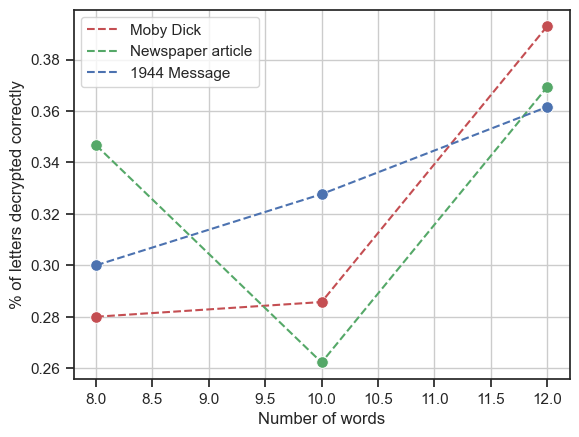

In [68]:
import seaborn as sns
# Create the plot using Seaborn
sns.set(style='ticks')

# Plotting the lines
sns.lineplot(x=lengths, y=Moby_Dick_accuracy, linestyle='--', color='r', label='Moby Dick')
sns.lineplot(x=lengths, y=article_tipping_accuracy, linestyle='--', color='g', label='Newspaper article')
sns.lineplot(x=lengths, y=speech_accuracy, linestyle='--', color='b', label='1944 Message')

# Adding scatter points
sns.scatterplot(x=lengths, y=Moby_Dick_accuracy, color='r', s = 70)
sns.scatterplot(x=lengths, y=article_tipping_accuracy, color='g', s = 70)
sns.scatterplot(x=lengths, y=speech_accuracy, color='b', s = 70)

# Adding labels and grid
plt.xlabel('Number of words')
plt.ylabel('% of letters decrypted correctly')
plt.grid(True)

# Adding legend
plt.legend()

# Display the plot
plt.show()